# ANALISI DELLO STATO ECONOMICO SANITARIO GLOBALE


## 1. Presentazione del Dataset

Il Dataset utilizzato è stato ricavato da Kaggle e prende in considerazione 167 Stati in riferimento a 9 variabili riferite ad aspetti economici e sanitari:

- *exports* indica le esportazioni di beni e servizi pro capite espresse in percentuale del PIL pro capite;
- *imports* indica le importazioni di beni e servizi pro capite espresse in percentuale del PIL pro capite;
- *income* indica il reddito netto pro capite;
- *inflation* indica la misura del tasso di crescita annuo del PIL totale;
- *gdpp* indica il PIL pro capite calcolato come il PIL totale diviso per la popolazione totale;
- *child_mort* indica il numero di bambini sotto i 5 anni morti ogni 1000 nascite;
- *health* indica la spesa sanitaria totale pro capite espressa come percentuale del PIL pro capite;
- *life_expec* indica il numero medio di anni che un neonato vivrebbe se gli attuali tassi di mortalità rimanessero inalterati;
- *total_fer* indica il numero di bambini che nascerebbero da ciascuna donna se gli attuali tassi di fertilità per età rimanessero inalterati.

Iniziamo l'analisi importando il dataset e verificando il numero di individui:

In [2254]:
# Importazione del dataset #

import pandas as pd

dataset = pd.read_csv('Country-data.csv', delimiter=',', header='infer')
dataset.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [2255]:
dataset['country']

0              Afghanistan
1                  Albania
2                  Algeria
3                   Angola
4      Antigua and Barbuda
              ...         
162                Vanuatu
163              Venezuela
164                Vietnam
165                  Yemen
166                 Zambia
Name: country, Length: 167, dtype: object

L'obiettivo di quest'analisi è applicare due tecniche di classificazione (*Decision Tree Classifier* e *Support Vector Machines*) per confrontarne i risultati. Successivamente verranno applicate diverse tecniche di *Clustering* per verificare quale ricava risultati migliori dal dataset.

# 2. Decision Tree Classifier

Il *Decision Tree Classifier* è un algoritmo di *Machine Learning* supervisionato usato sia per i compiti di classificazione, che per quelli di regressione. Le decisioni e le conseguenze di queste vengono modellizzate in una struttura ad albero, costruito dividendo i dati sulla base dei valori delle caratteristiche che meglio predicono la variabile target. L'obiettivo è creare un albero che sia in grado di classificare nuovi dati seguendo la struttura creata.

Per procedere si imposta l'analisi in base ad una divisione binaria utilizzando come criterio di classificazione la variabile *gdpp*, ovvero il PIL pro capite di ogni Stato. In tale modo il dataset verrà diviso in **Stati in via di sviluppo** e **Stati sviluppati** a seconda che il valore di *gdpp* sia inferiore o maggiore a 10000. Il valore soglia è stato scelto in modo arbitrario a fini didattici.

Successivamente costruiamo un dataset che prenda in considerazione le variabili del dataset di partenza che maggiormente influenzano lo status di sviluppo di uno Stato, ossia la mortalità infantile, il reddito, l'aspettativa di vita e le spese sanitarie nazionali. 
Procediamo con l'addestramento del modello a cui applichiamo il *Gini Index*.

In [2256]:
# DECISION TREE CLASSIFIER #

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# Definizione di variabili e target
dataset["status"] = dataset["gdpp"].apply(lambda x: 1 if x > 10000 else 0)

X = dataset[["child_mort", "income", "life_expec", "health"]]
y = dataset["status"]

# Addetrare il modello
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
clf = DecisionTreeClassifier(criterion="gini",random_state=42, max_depth=4)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=4, random_state=42)

Infine generiamo l'albero decisionale:

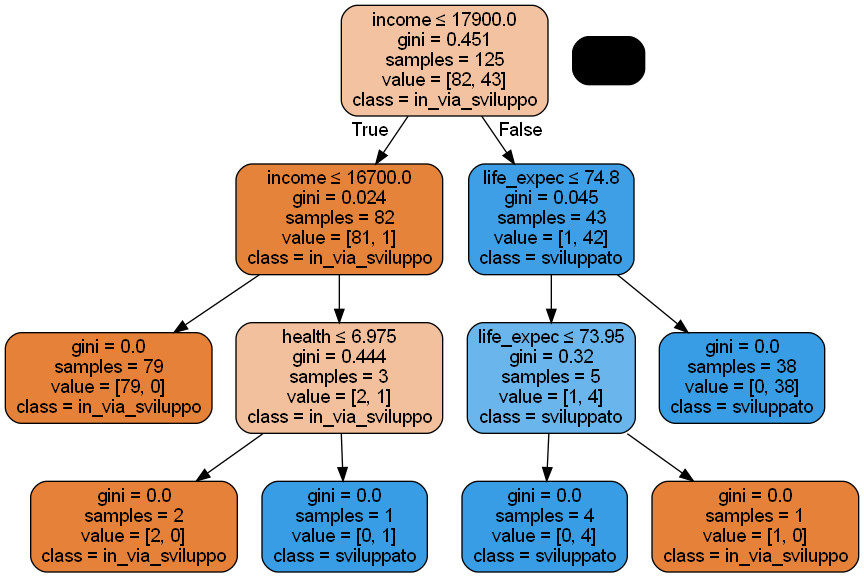

In [2257]:
from sklearn import tree
import pydotplus
from IPython.display import Image

# Costruzione dell'albero decisionale
dot_data = tree.export_graphviz(
    clf,
    feature_names=X.columns,
    class_names=['in_via_sviluppo','sviluppato'],
    filled=True,
    rounded=True,
    special_characters=True,
    out_file=None)

# Visualizzazione del grafico
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())


Il primo nodo valuta il reddito: se è inferiore o uguale a 17.900, il paese viene generalmente classificato come **in via di sviluppo**. In questa fascia, se il reddito è molto basso (≤16.700), non servono ulteriori controlli, mentre nei casi intermedi si considera l’indice di spesa sanitaria. Per i paesi con reddito più alto, il modello guarda l’aspettativa di vita: se è elevata (oltre 74.8), il paese è classificato come **sviluppato**, altrimenti si valutano soglie più fini. Questo albero mostra che il *reddito* è il criterio principale, ma nei casi ambigui entrano in gioco anche *spesa sanitaria* e *aspettativa di vita* per una classificazione più precisa.


Procediamo calcolando l'accuratezza del modello:

In [2258]:
# Determinare l'Accuracy Score
from sklearn.metrics import accuracy_score

predY = clf.predict(X_test)
print("L'accuratezza dei dati test è %.2f" % (accuracy_score(y_test, predY)))

L'accuratezza dei dati test è 0.88


L'accuratezza del modello è 88%, di conseguenza le predizioni sono molto accurate.
Per verificare che il modello sia in grado di generalizzare efficacemente i risultati creiamo una *Matrice di Confusione*.
La Matrice di Confusione confronta le etichette reali con quelle predette, creando una matrice che mostra quanti Stati sono stati classificati correttamento o meno nelle due categorie di status.

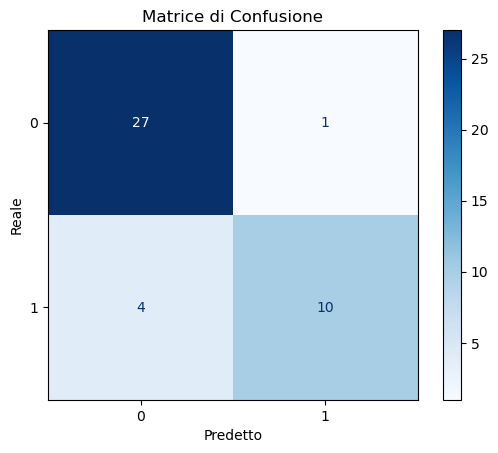

In [2259]:
# Visualizzazione della matrice di confusione
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predY, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione")
plt.ylabel("Reale")
plt.xlabel("Predetto")
plt.show()

Possiamo affermare che l’albero decisionale ha una buona accuratezza complessiva: identifica correttamente la maggior parte dei casi della classe 0 (**in via di sviluppo**) ma tende a confondere alcuni esempi della classe **sviluppata** classificandoli come **in via di sviluppo**, come mostrano i 4 falsi negativi.

# 3. Support Vector Machines

Il *Support Vector Machines (SVM)* è un algoritmo di apprendimento supervisionato utilizzato per la classificazione, il cui obiettivo principale è quello di trovare un iperpiano che separa i dati in classi distinte con il margine più ampio possibile di distanza tra i punti di altre classi. Se i dati non sono separabili linearmente, le SVM utilizzano i kernel, che trasformano i dati in modo da renderne possibile la separazione.

In [2260]:
# Support Vector Machine #

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt


Per procedere all'utilizzo dell' *SVM* dobbiamo decidere quale kernel usare:

In [2261]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
import numpy as np

# Paragone dei diversi kernel
kernels = ["linear", "rbf", "poly", "sigmoid"]
scores = {}

for kernel in kernels:
    model = SVC(kernel=kernel)
    score = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    scores[kernel] = score
    print(f"Kernel: {kernel}\tAccuracy media: {np.mean(score):.4f} ± {np.std(score):.4f}")

Kernel: linear	Accuracy media: 0.9337 ± 0.0485
Kernel: rbf	Accuracy media: 0.9460 ± 0.0348
Kernel: poly	Accuracy media: 0.9283 ± 0.0517
Kernel: sigmoid	Accuracy media: 0.6225 ± 0.0278


Graficamente:

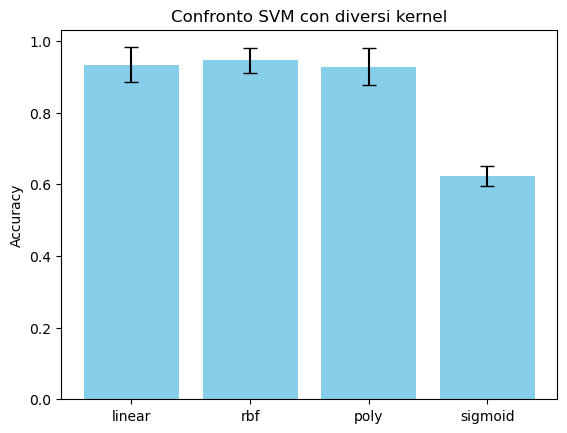

In [2262]:
# Visualizzazione dell'accuratezza media per ogni kernel
import matplotlib.pyplot as plt

means = [np.mean(scores[k]) for k in kernels]
errors = [np.std(scores[k]) for k in kernels]

plt.bar(kernels, means, yerr=errors, color="skyblue", capsize=5)
plt.ylabel("Accuracy")
plt.title("Confronto SVM con diversi kernel")
plt.show()

L'accuracy più alta si trova per il kernel *Radial Basis Funcion (rbf)*. Per brevità verranno mostrati solo i risultati di tale kernel. 

Succesivamente dobbiamo individuare l'iperparametro C più adatto per il modello. Usiamo la funzione *GridSearchCV* per esplorare una griglia di valori iperparametrici per valutarne l'accuratezza:

In [2263]:
# Ricerca del miglior parametro C per SVM con kernel RBF 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=5, scoring='accuracy')
grid.fit(X, y)

print("Miglior valore di C:", grid.best_params_['C'])
print("Accuracy media:", grid.best_score_)

Miglior valore di C: 1
Accuracy media: 0.9459893048128342


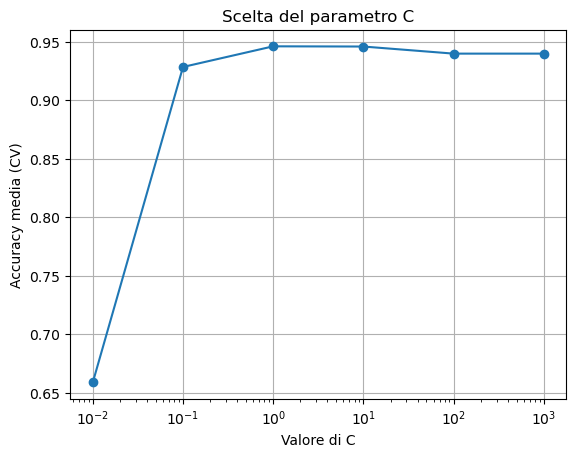

In [2264]:
# Visualizzazione dell'accuratezza media per ogni valore di C
import matplotlib.pyplot as plt

results = grid.cv_results_
plt.plot(param_grid['C'], results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel("Valore di C")
plt.ylabel("Accuracy media (CV)")
plt.title("Scelta del parametro C")
plt.grid(True)
plt.show()

L'iperparametro con l'accuracy maggiore è C = 1. Dal grafico si può osservare che dopo tale valore l'accuracy decresce.

Successivamente verrà scelta la coppia di feauture da usare nella rappresentazione del confine decisionale. Anche in questo caso la soglia del classificatore binario dipende dal valore di *gdpp*.

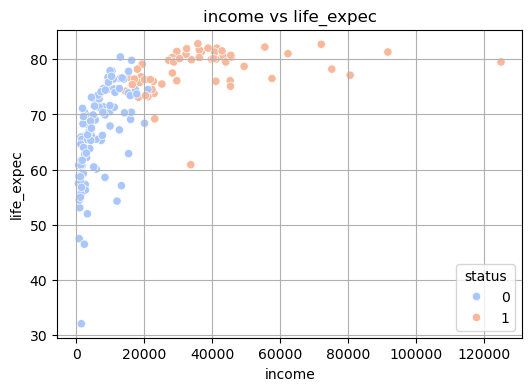

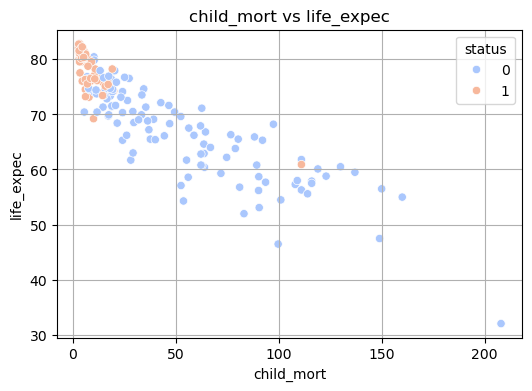

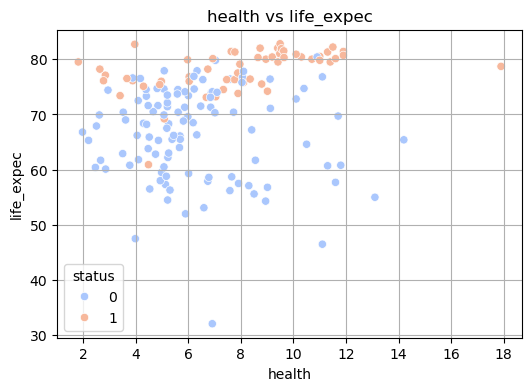

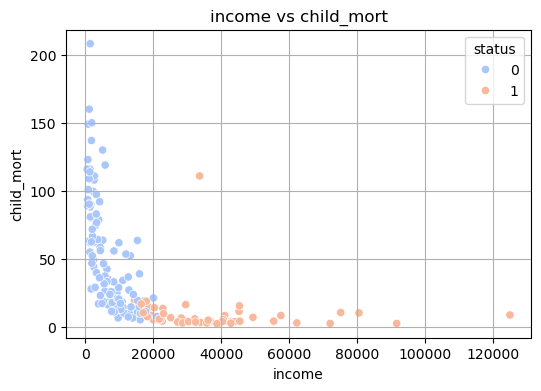

In [2265]:
import matplotlib.pyplot as plt
import seaborn as sns

# Etichette binarie 
dataset["status"] = dataset["gdpp"].apply(lambda x: 1 if x > 10000 else 0)

def plot_pair(x, y):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=dataset, x=x, y=y, hue="status", palette="coolwarm")
    plt.title(f"{x} vs {y}")
    plt.grid(True)
    plt.show()

# Coppie possibili da analizzare:
plot_pair("income", "life_expec")
plot_pair("child_mort", "life_expec")
plot_pair("health", "life_expec")
plot_pair("income", "child_mort")


Le feature scelte sono *income* e *child_mort*, in quanto sono le più discriminanti per separare gli stati in via di sviluppo da quelli sviluppati.

Per trovare il confine decisionale rappresentiamo la distribuzione degli Stati ponendo sull'asse X la variabile *income* e sull'asse Y la variabile *child_mort*, entrambe le variabili verranno standardizzate.

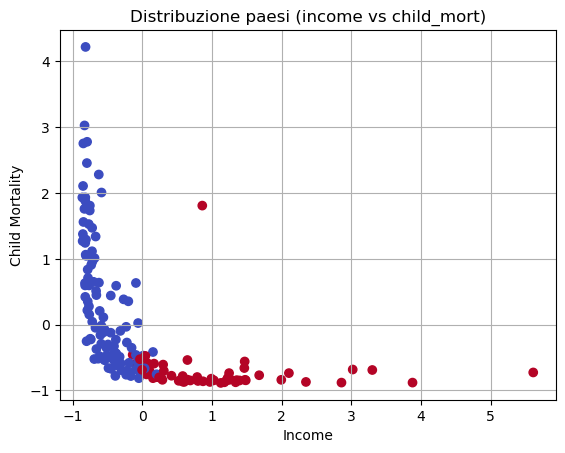

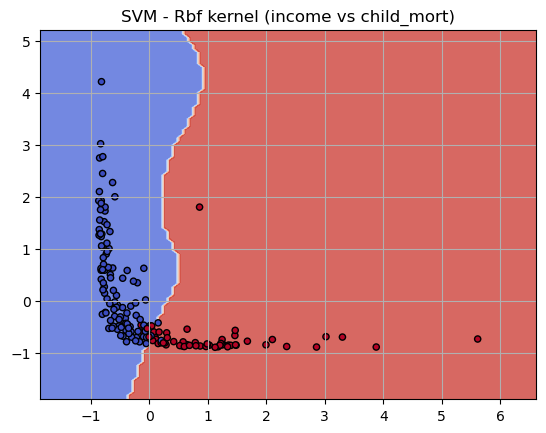

In [2266]:
# Decision Boundary con SVM e RBF kernel #

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import DecisionBoundaryDisplay

X = dataset[["income", "child_mort"]].values
y = [1 if x > 10000 else 0 for x in dataset["gdpp"]] # Etichette binarie: 1 = sviluppato, 0 = in via di sviluppo
X = StandardScaler().fit_transform(X)

# Visualizzazione dei punti 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
plt.title("Distribuzione paesi (income vs child_mort)")
plt.xlabel("Income")
plt.ylabel("Child Mortality")
plt.grid(True)
plt.show()

# Visualizzazione del Decision Boundary
model = SVC(kernel="rbf", gamma=0.7, C=1) # Kernel rbf
model.fit(X, y)

fig, ax = plt.subplots()
disp = DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    response_method="predict",
    cmap=plt.cm.coolwarm,
    alpha=0.8,
    ax=ax,
)

X0, X1 = X[:, 0], X[:, 1]
ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
ax.set_title("SVM - Rbf kernel (income vs child_mort)")
plt.grid(True)
plt.show()


Ogni punto rappresenta uno Stato, colorato in base alla classe predetta dal modello *SVM*. Lo sfondo è diviso in due aree colorate, che indicano le regioni decisionali apprese dal classificatore: gli elementi che cadono nel blu vengono classificati nella classe **sviluppato**, mentre quelli che cadono nel rosso vengono classificati nella classe **in via di sviluppo**.
La curva di separazione tra le due regioni non è lineare, segno che il kernel RBF è riuscito a catturare una relazione complessa tra le due variabili. Osservando la distribuzione, possiamo affermare che la maggior parte dei paesi con basso reddito e alta mortalità infantile si trova nel settore blu, mentre quelli con reddito più elevato e mortalità infantile più bassa ricadono nella regione rossa. Ci sono pochi punti vicini alla frontiera di decisione, che potrebbero rappresentare i casi più ambigui per il modello.
In generale il modello *SVM* con kernel RBF ha appreso una *decision boundary* flessibile, che sembra adattarsi bene alla distribuzione dei dati, separando con discreta efficacia i due gruppi.

Infine creiamo la Matrice di Confusione per l'*SVM*:

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        28
           1       1.00      0.71      0.83        14

    accuracy                           0.90        42
   macro avg       0.94      0.86      0.88        42
weighted avg       0.92      0.90      0.90        42



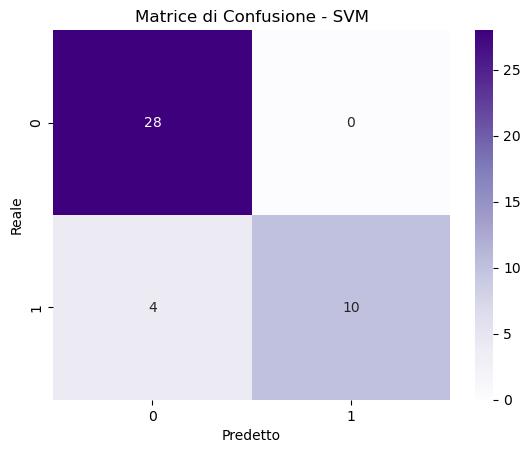

In [2267]:
# Addestramento del classificatore
svm = SVC(kernel='rbf', C=1, gamma='scale')  
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Report prestazioni SVM
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Matrice di confusione SVM
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, cmap="Purples", fmt="d")
plt.title("Matrice di Confusione - SVM")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()


L'*accuracy* dell'*SVM* è 90%, quindi, possiamo affermare che questo modello ha delle ottime prestazioni. Come è possibile osservare dalla *Matrice di Confusione* il modello classifica correttamente quasi tutti gli elementi ad eccezione di 4 falsi positivi.

# 4. Clustering

La *Cluster Analysis* permette il raggruppamento di oggetti sulla base delle loro caratteristiche, in modo che vi sia un'elevata similarità intra-cluster e una ridotta similarità inter-cluster. Nel corso della seguente analisi verranno utilizzate diverse tecniche di *Clustering* per determinare, attraverso la *Cluster Validity* quale algoritmo ricava risultati migliori dal dataset in esame.

## 4.1 K-means Clustering

L'algoritmo *k-means* è tecnica di apprendimento non supervisionato utilizzata per raggruppare gli elementi dati in k gruppi, dove ogni gruppo è definito dal suo centroide (media). Assegna iterativamente i punti dati al *cluster* più vicino e quindi aggiorna i centroidi del cluster fino alla convergenza, minimizzando la varianza all'interno del cluster. In questa analisi verrà utilizzato il dataset completo standardizzato.

In [2268]:
# K-means Clustering #

from sklearn.preprocessing import StandardScaler

X = dataset.drop(columns=["country", "status"], errors="ignore")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Per procedere all'utilizzo dell'algoritmo *K-means* dobbiamo determinare K, ossia il numero di *cluster* in cui i dati vengono distribuiti.

c:\Users\Utente\anaconda3\envs\DMtest\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\DMtest\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\DMtest\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Utente\anaconda3\envs\DMtest\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarn

Text(0, 0.5, 'SSE')

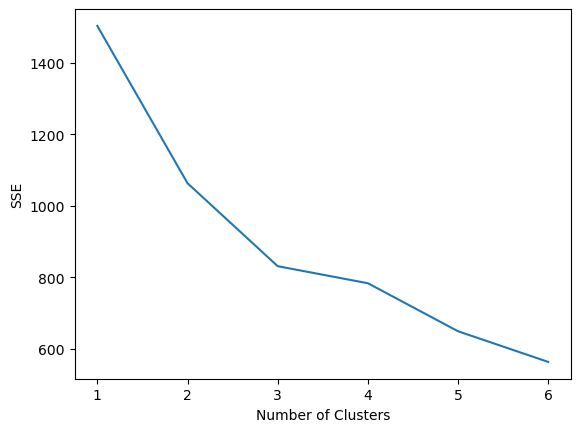

In [2269]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
%matplotlib inline

# Determinazione del numero ottimale di cluster con il metodo del gomito
numClusters = [1,2,3,4,5,6]
SSE = []
for k in numClusters:
    k_means = KMeans(n_clusters=k)
    k_means.fit(X_scaled)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

Utilizzando la regola del gomito possiamo osservare che dopo K=3 lo SSE diminuisce lentanmente, tuttavia da un confronto dei risultati tra K=3 e K=4 abbiamo determinato che *Silhouette score* e *correlazione* hanno prestazioni migliori con K=4. 

In [2270]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=4, random_state=42) # Il numero di cluster è 4
kmeans_labels = kmeans.fit_predict(X_scaled)

dataset["kmeans_cluster"] = kmeans_labels

centroids = kmeans.cluster_centers_ # Visualizzazione dei centroidi
feature_cols = dataset.drop(columns=["country", "status", "kmeans_cluster", "agg_cluster", "dbscan_cluster"], errors="ignore").columns
pd.DataFrame(centroids, columns=feature_cols)



c:\Users\Utente\anaconda3\envs\DMtest\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,-0.393282,-0.030584,-0.206179,0.019562,-0.250930,-0.005783,0.226762,-0.402579,-0.355832
1,-0.827449,0.645080,0.727411,0.190639,1.484243,-0.484921,1.079579,-0.791877,1.615995
2,1.393841,-0.454869,-0.177681,-0.166445,-0.709743,0.200563,-1.300734,1.391209,-0.613462
3,2.281385,-0.578452,-0.637438,-1.221785,-0.624065,9.129718,-1.134121,1.916133,-0.581936


Dopo aver determinato il numero di *cluster* visualizziamo la distribuzione degli elementi, come per il *decision boundary*, poniamo sull'asse X la variabile *income* e sull'asse Y la variabile *child_mort*.

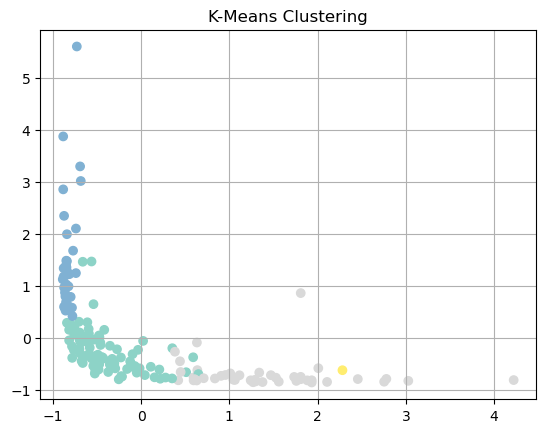

In [2271]:
# Visualizzazione dei cluster K-means
plt.scatter(X_scaled[:, 0], X_scaled[:, 4], c=kmeans_labels, cmap="Set3") # Gli assi fanno riferimento alle feautures "income" e "child_mort"
plt.title("K-Means Clustering")
plt.grid(True)
plt.show()

Determiniamo il numero di elementi in ogni *cluster*:

In [2272]:
# Numero di paesi in ogni cluster
for cluster in np.unique(kmeans_labels):
    print(f"Numero di paesi nel cluster {cluster}: {sum(kmeans_labels == cluster)}")


Numero di paesi nel cluster 0: 86
Numero di paesi nel cluster 1: 36
Numero di paesi nel cluster 2: 44
Numero di paesi nel cluster 3: 1


E il nome degli Stati appartenenti a ciascun *cluster*:

In [2273]:
# Nomi dei paesi in ogni cluster
for cluster in np.unique(kmeans_labels):
    print(f"\n Paesi nel cluster {cluster}:")
    print(*dataset["country"][kmeans_labels == cluster], sep=", ")



 Paesi nel cluster 0:
Albania, Algeria, Antigua and Barbuda, Argentina, Armenia, Azerbaijan, Bahamas, Bangladesh, Barbados, Belarus, Belize, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Bulgaria, Cambodia, Cape Verde, Chile, China, Colombia, Costa Rica, Croatia, Dominican Republic, Ecuador, Egypt, El Salvador, Estonia, Fiji, Georgia, Grenada, Guatemala, Guyana, Hungary, India, Indonesia, Iran, Iraq, Jamaica, Jordan, Kazakhstan, Kyrgyz Republic, Latvia, Lebanon, Libya, Lithuania, Macedonia, FYR, Malaysia, Maldives, Mauritius, Micronesia, Fed. Sts., Moldova, Mongolia, Montenegro, Morocco, Myanmar, Nepal, Oman, Panama, Paraguay, Peru, Philippines, Poland, Romania, Russia, Samoa, Saudi Arabia, Serbia, Seychelles, Solomon Islands, Sri Lanka, St. Vincent and the Grenadines, Suriname, Tajikistan, Thailand, Tonga, Tunisia, Turkey, Turkmenistan, Ukraine, Uruguay, Uzbekistan, Vanuatu, Venezuela, Vietnam

 Paesi nel cluster 1:
Australia, Austria, Bahrain, Belgium, Brunei, Canada, C

Il *Cluster 1* raggruppa le nazioni più sviluppate, tra cui Stati Uniti, Germania, Giappone e Australia, caratterizzate da elevati livelli di reddito, sistemi sanitari avanzati e indicatori di benessere molto alti. Il *Cluster 0* include invece una vasta gamma di Paesi emergenti e in via di sviluppo, come Brasile, India, Cina e molti Stati dell’Europa orientale e dell’America Latina, che mostrano condizioni intermedie: sviluppo in crescita, ma ancora segnato da criticità in ambito economico o sanitario. Il *Cluster 2* è composto principalmente da Paesi dell’Africa subsahariana e da altri con gravi difficoltà economiche e sociali, come Afghanistan, Yemen o Haiti, accomunati da bassi livelli di reddito, alta mortalità infantile e sistemi sanitari fragili. Infine, la Nigeria è stata isolata nel *Cluster 3*, probabilmente per via di caratteristiche particolarmente estreme o anomale nei dati, che la rendono significativamente diversa anche rispetto agli altri Paesi meno sviluppati.


Per determinare la validità dei risultati utilizziamo il *Silhouette Score*, ovvero una metrica che misura quanto bene un punto è assegnato al proprio cluster rispetto agli altri cluster:

In [2274]:
# Cluster validity per K-means #

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances

scaler = StandardScaler()
scaleddf = scaler.fit_transform(dataset.drop(columns=['country'], errors='ignore'))
k = 4
kmeans = KMeans(n_clusters=k, random_state=0)
labels_kmeans = kmeans.fit_predict(scaleddf)

# Silhouette score globale
score = silhouette_score(scaleddf, labels_kmeans)
print(f"Silhouette Score globale (KMeans, k={k}): {score:.3f}")

# Silhouette score per cluster
silhouette_vals = silhouette_samples(scaleddf, labels_kmeans)
for cluster_id in np.unique(labels_kmeans):
    cluster_sil = [s for s, l in zip(silhouette_vals, labels_kmeans) if l == cluster_id]
    print(f"Silhouette medio per cluster {cluster_id}: {np.mean(cluster_sil):.3f}")

c:\Users\Utente\anaconda3\envs\DMtest\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Silhouette Score globale (KMeans, k=4): 0.358
Silhouette medio per cluster 0: 0.403
Silhouette medio per cluster 1: 0.436
Silhouette medio per cluster 2: 0.265
Silhouette medio per cluster 3: 0.345


In generale i valori del *Silhouette score* non sono nè particolarmente elevati nè troppo bassi, il valore maggiore si riscontra per il *cluster 1*. 
Successivamente calcoliamo la *Matrice di Similarità* e la *Matrice di Incidenza* per visualizzare e a valutare la coerenza interna dei *cluster*. 

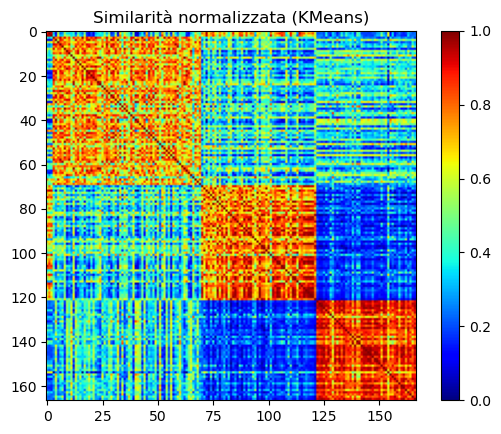

In [2275]:
# Matrice di similarità per K-means
pairwise_dist = pairwise_distances(scaleddf, metric='cosine') # Distanza del coseno
sorted_indices = np.argsort(labels_kmeans)
sorted_dist = pairwise_dist[sorted_indices][:, sorted_indices]
sorted_dist /= np.max(sorted_dist)  
sorted_sim = 1 - sorted_dist

# Visualizzazione della matrice di similarità
plt.figure()
plt.imshow(sorted_sim, cmap='jet')
plt.title("Similarità normalizzata (KMeans)")
plt.colorbar()
plt.show()

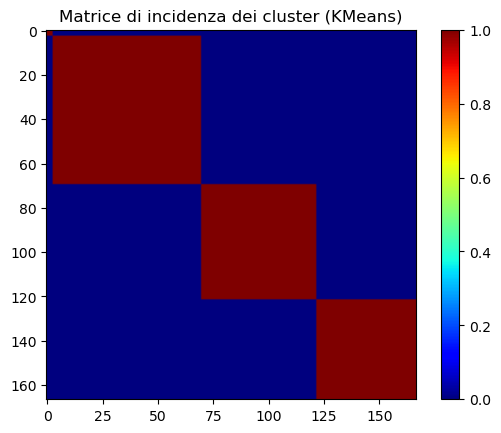

In [2276]:
# Matrice di incidenza per K-means
labels_sorted = labels_kmeans[sorted_indices]
incidence_matrix = (labels_sorted[:, None] == labels_sorted).astype(int)

# Visualizzazione della matrice di incidenza
plt.figure()
plt.imshow(incidence_matrix, cmap='jet')
plt.title("Matrice di incidenza dei cluster (KMeans)")
plt.colorbar()
plt.show()

Infine calcoliamo il *Coefficiente di Correlazione*:

In [2277]:
# Correlazione tra distanza e incidenza per K-means
corr = np.corrcoef(sorted_dist.flatten(), incidence_matrix.flatten())[0, 1]
print(f"Coefficiente di correlazione (distanza vs cluster - KMeans): {corr:.3f}")

Coefficiente di correlazione (distanza vs cluster - KMeans): -0.770


Il coefficiente di correlazione pari a -0.770 indica una forte correlazione negativa tra le due matrici. Possiamo affermare che più due Paesi sono simili (cioè la loro distanza è piccola), maggiore è la probabilità che appartengano allo stesso cluster. Al contrario, Paesi con caratteristiche molto diverse (cioè distanti nella matrice di similarità) tendono a essere assegnati a cluster differenti. Questo risultato è un ottimo indicatore della coerenza interna del clustering, quindi l'algoritmo *K-Means* ha raggruppato in modo efficace Paesi con profili simili, rispettando la struttura dei dati originali.

## 4.2 Clustering Gerarchico

Il *clustering* gerarchico è un algoritmo di machine learning non supervisionato che raggruppa i dati in una struttura ad albero di cluster annidati. I risultati vengono rappresentati in un dendrogramma, che mostra le relazioni di distanza tra i cluster. Anche in questo caso verrà utilizzato il dataset completo standardizzato. Dal confronto dei risultati abbiamo determinato che il metodo agglomerativo di *Ward*, secondo cui la similarità di due cluster si basa sull'aumento dell'errore quadratico (SSE) quando due cluster vengono uniti.

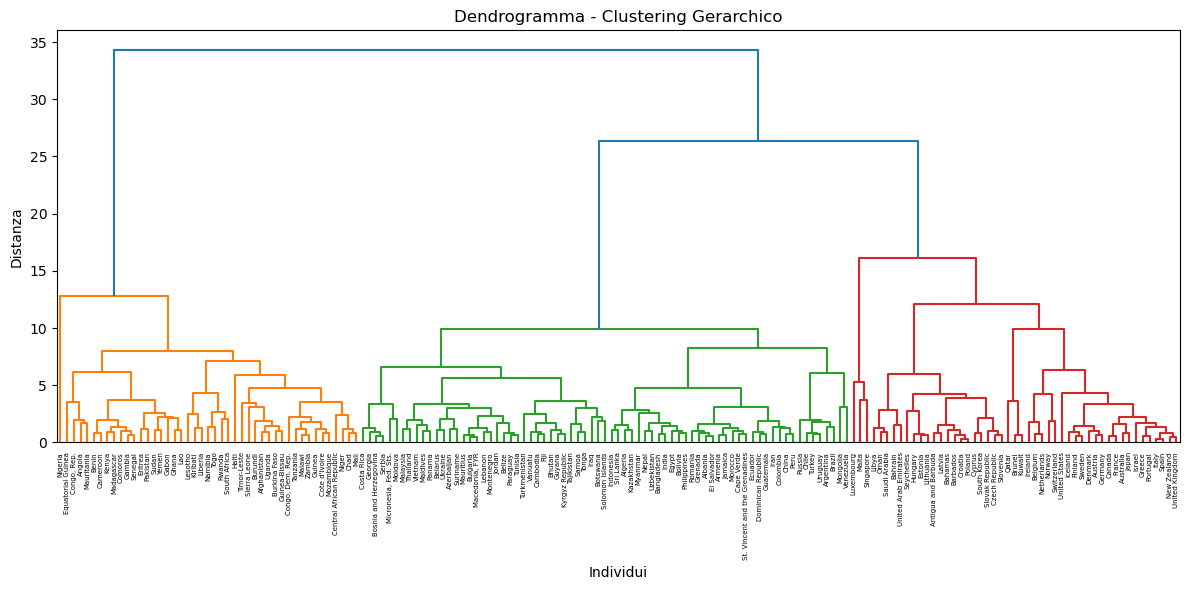

In [2278]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from sklearn.preprocessing import StandardScaler

# Clustering gerarchico con dendrogramma
scaler = StandardScaler()  
data_scaled = scaler.fit_transform(dataset.drop('country', axis=1))
linkage_matrix = linkage(data_scaled, method='ward') # Metodo di Ward
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, labels=dataset["country"].tolist(), leaf_rotation=90)
plt.title("Dendrogramma - Clustering Gerarchico")
plt.xlabel("Individui")
plt.ylabel("Distanza")
plt.tight_layout()
plt.show()
from scipy.cluster.hierarchy import fcluster

n_clusters = 3
labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

Gli Stati vengono distribuiti in 3 ampi *cluster*. Determiniamo il numero di elementi in ogni *cluster*:

In [2279]:
import numpy as np
from scipy.cluster.hierarchy import fcluster

labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
dataset["Cluster_HC"] = labels

# Numero di paesi in ogni cluster
for cluster in np.unique(labels):
    print(f"Numero di paesi nel cluster {cluster}: {sum(labels == cluster)}")



Numero di paesi nel cluster 1: 45
Numero di paesi nel cluster 2: 73
Numero di paesi nel cluster 3: 49


E il nome degli Stati appartenenti a ciascun *cluster*:

In [2280]:
# Nomi dei paesi in ogni cluster
for cluster in np.unique(labels):
    print(f"\n Paesi nel cluster {cluster}:")
    print(*dataset.loc[dataset["Cluster_HC"] == cluster, "country"], sep=", ")




 Paesi nel cluster 1:
Afghanistan, Angola, Benin, Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Comoros, Congo, Dem. Rep., Congo, Rep., Cote d'Ivoire, Equatorial Guinea, Eritrea, Gabon, Gambia, Ghana, Guinea, Guinea-Bissau, Haiti, Kenya, Kiribati, Lao, Lesotho, Liberia, Madagascar, Malawi, Mali, Mauritania, Mozambique, Namibia, Niger, Nigeria, Pakistan, Rwanda, Senegal, Sierra Leone, South Africa, Sudan, Tanzania, Timor-Leste, Togo, Uganda, Yemen, Zambia

 Paesi nel cluster 2:
Albania, Algeria, Argentina, Armenia, Azerbaijan, Bangladesh, Belarus, Belize, Bhutan, Bolivia, Bosnia and Herzegovina, Botswana, Brazil, Bulgaria, Cambodia, Cape Verde, Chile, China, Colombia, Costa Rica, Dominican Republic, Ecuador, Egypt, El Salvador, Fiji, Georgia, Grenada, Guatemala, Guyana, India, Indonesia, Iran, Iraq, Jamaica, Jordan, Kazakhstan, Kyrgyz Republic, Lebanon, Macedonia, FYR, Malaysia, Maldives, Mauritius, Micronesia, Fed. Sts., Moldova, Mongolia, Montenegro, Morocco, Myanm

Il *Cluster 1* raggruppa prevalentemente Paesi dell’Africa subsahariana, insieme ad alcune nazioni dell’Asia meridionale e dello Yemen. Si tratta di Stati con basso reddito pro capite, alta mortalità infantile e servizi sanitari carenti, che rappresentano i contesti più svantaggiati a livello globale. Il *Cluster 2* comprende Paesi emergenti o in via di sviluppo come India, Brasile, Cina, Egitto e Turchia, che mostrano migliori condizioni rispetto al Cluster 1, ma non hanno ancora raggiunto i livelli di benessere delle economie più avanzate, sono Stati in fase di transizione con un miglioramento graduale degli indicatori socioeconomici. Il *Cluster 3* è costituito dai Paesi più sviluppati, come Stati Uniti, Germania, Giappone, Australia e la maggior parte dei membri dell’Unione Europea, oltre a ricche economie del Golfo, questi Paesi sono caratterizzati da elevati livelli di reddito, bassa mortalità infantile e sistemi sanitari efficienti.

Ora determiniamo la *Cluster Validity* per il *clustering gerarchico*:

In [2281]:
# Cluster validity per Clustering Gerarchico 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances
from scipy.cluster.hierarchy import fcluster

cols_to_drop = ["country", "status", "kmeans_cluster", "agg_cluster", "dbscan_cluster", "gmm_cluster", "spectral_cluster", "Cluster_HC"]
X = dataset.drop(columns=cols_to_drop, errors='ignore')
scaler = StandardScaler()
scaleddf = scaler.fit_transform(X)

# Etichette dei cluster gerarchici
labels_hc = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

# Silhouette score e media per cluster
hc_silhouette = silhouette_score(scaleddf, labels_hc)
print(f"Silhouette score globale: {hc_silhouette:.3f}")

hc_silhouette_samples = silhouette_samples(scaleddf, labels_hc)

for cluster_id in np.unique(labels_hc):
    sil_values = [s for s, l in zip(hc_silhouette_samples, labels_hc) if l == cluster_id]
    print(f"Silhouette valore medio per cluster {cluster_id}: {np.mean(sil_values):.3f}")

Silhouette score globale: 0.237
Silhouette valore medio per cluster 1: 0.226
Silhouette valore medio per cluster 2: 0.348
Silhouette valore medio per cluster 3: 0.083


In generale il *Silhouette Score* è basso, quindi si riscontra incertezza nell'assegnazione ai *cluster*. Il *cluster 3* ha un valore prossimo allo 0.
Procediamo visualizzando la *Matrice di Similarità* e la *Matrice di Incidenza*:

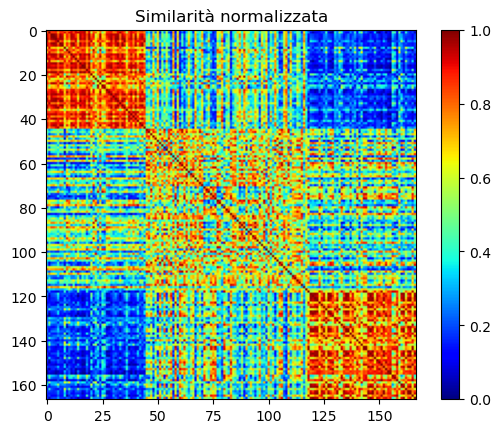

In [2282]:
# Matrice di similarità per Clustering Gerarchico
pairwise_dist = pairwise_distances(scaleddf, metric='cosine')
sorted_indices = np.argsort(labels_hc)
sorted_dist = pairwise_dist[sorted_indices][:, sorted_indices]
sorted_dist /= np.max(sorted_dist)  
sorted_sim = 1 - sorted_dist

plt.imshow(sorted_sim, cmap='jet')
plt.title("Similarità normalizzata")
plt.colorbar()
plt.show()

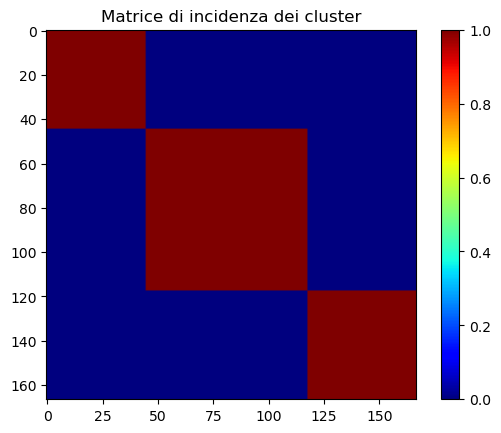

In [2283]:
# Matrice di incidenza per Clustering Gerarchico
labels_sorted = labels_hc[sorted_indices]
incidence_matrix = (labels_sorted[:, None] == labels_sorted).astype(int)

plt.imshow(incidence_matrix, cmap='jet')
plt.title("Matrice di incidenza dei cluster")
plt.colorbar()
plt.show()

E calcoliamo il *Coefficiente di Correlazione*:

In [2284]:
# Correlazione tra distanza e incidenza per Clustering Gerarchico
corr = np.corrcoef(sorted_dist.flatten(), incidence_matrix.flatten())[0, 1]
print(f"Coefficiente di correlazione (distanza vs cluster): {corr:.3f}")

Coefficiente di correlazione (distanza vs cluster): -0.562


Il valore di -0.562 mostra che il clustering gerarchico cattura parzialmente la struttura di similarità nei dati, ma non in modo ottimale.

## 4.3 Confronto tra i metodi di *clustering*

Nel confronto tra il *clustering K-Means* e il *clustering gerarchico* emergono differenze significative in termini di qualità e coerenza dei *cluster* ottenuti. Il *Silhouette Score*, è 0.358 per *K-Means* e 0.237 per il *clustering gerarchico*. Questo indica che il *K-Means* ha formato *cluster* più compatti e meglio definiti, mentre il *clustering gerarchico* ha generato gruppi meno distinti e con maggiore sovrapposizione.
Un altro indicatore utile è il *coefficiente di correlazione tra la matrice di similarità e la matrice di incidenza*. Per il *K-Means* la correlazione è -0.77, mentre per il *clustering gerarchico* è -0.562. Il valore più elevato del *K-Means* suggerisce una maggiore coerenza tra la distanza effettiva e la struttura dei *cluster*: i punti distanti tra loro sono quasi sempre in *cluster* diversi, a conferma della sua maggiore efficacia nel separare i dati. Infine, anche osservando la distribuzione dei paesi nei vari *cluster*, il *K-Means* ha evidenziato una segmentazione più chiara, con *cluster* che distinguono nettamente tra paesi sviluppati, in via di sviluppo e meno sviluppati, arrivando persino a isolare un paese con caratteristiche particolari (Nigeria). Al contrario, il *clustering gerarchico* ha prodotto gruppi più eterogenei, con una maggiore mescolanza di paesi diversi per caratteristiche socioeconomiche.

In generale possiamo affermare che il *clustering K-Means* è più efficace per questo dataset rispetto al *clustering gerarchico*.


# 5. Conclusioni